# Check training result

In [1]:
TEST_CODE = "1560421960.106101"
CHOSEN_EPOCH = 45

MODEL_PATH = "../log/{}/models/epoch_{}".format(TEST_CODE, CHOSEN_EPOCH)
LOG_PATH = "../log/{}/log.txt".format(TEST_CODE)

In [2]:
log = open(LOG_PATH).readlines()

Parameter

In [3]:
log[0]

"Namespace(base_lr=0.003, batch_size=2048, decay_epoch_step=50, display_step=1, grad_clip=False, hidden_neuron=1000, lambda_value=1, optimizer_method='Adam', random_seed=1000, train_epoch=200)\n"

In [4]:
train_log = log[1::4]
test_log = log[3::4]

In [5]:
train_cost = [float(line.split('\t')[1].replace("Total cost = ","")) for line in train_log][:-1]
test_cost = [float(line.split('\t')[1].replace("Total cost = ","")) for line in test_log]
test_RMSE = [float(line.split('\t')[2].replace("RMSE = ","")) for line in test_log]

In [6]:
n_train = int(138493 * 0.9)
n_test = int(138493 * 0.1)

train_cost = [x/n_train for x in train_cost]
test_cost = [x/n_test for x in test_cost]

## Plot

In [7]:
import matplotlib.pyplot as plt

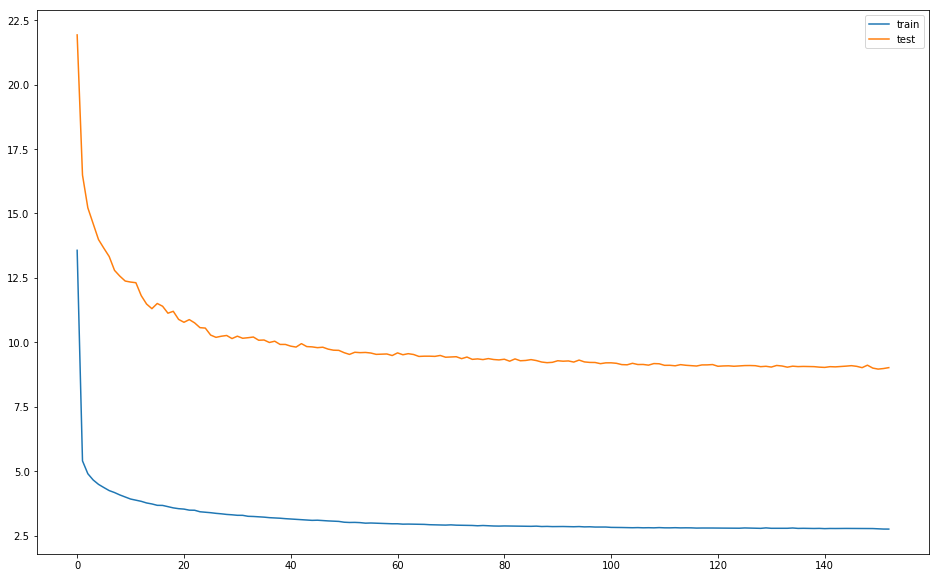

In [8]:
plt.figure(figsize=(16,10))
plt.plot(range(0, len(train_cost)), train_cost, label="train")
plt.plot(range(0, len(train_cost)), test_cost, label="test")
plt.legend()

# Model

In [9]:
class Args:
    
    def __init__(self):
        self.hidden_neuron = 1000
        self.lambda_value = 1.0
        
        self.train_epoch = 200
        self.batch_size = 2048
        
        self.optimizer_method = 'Adam' # 'Adam','RMSProp'
        self.grad_clip = False
        self.base_lr = 0.003
        self.decay_epoch_step = 50
        
        self.random_seed = 1000
        self.display_step = 1
        
    def __str__(self):
        return "hidden_neuron : {}\nlambda_value : {}\ntrain_epoch : {}\nbatch_size : {}\noptimizer_method : {}\ngrad_clip : {}\nbase_lr : {}\ndecay_epoch_step : {}\nrandom_seed : {}\ndisplay_step : {}\n".format(
            self.hidden_neuron,
            self.lambda_value,
            self.train_epoch,
            self.batch_size,
            self.optimizer_method,
            self.grad_clip,
            self.base_lr,
            self.decay_epoch_step,
            self.random_seed,
            self.display_step)

args = Args()

In [10]:
import pickle
import os

class Logger:

    def set_default_filename(self, filename):
        self.default_filename = filename

    def create_session_folder(self, path):
        try:  
            os.makedirs(path)
        except OSError:  
            print ("Creation of the directory %s failed" % path)
        else:  
            print ("     ===> Successfully created the directory %s \n" % path)

    def log(self, text):
        with open(self.default_filename, 'a') as f:
            f.writelines(text)
            f.write("\n")

    def save_model(self, model, filename):
        pickle.dump(model, open(filename, 'wb'))
    
    

In [11]:
import tensorflow as tf
import time
import numpy as np
import os
import math
from datetime import datetime
from scipy.sparse import lil_matrix, csr_matrix, vstack
from tqdm import tqdm

class AutoRec():
    def __init__(self, sess, args,
                 num_users, num_items,
                 R, mask_R, train_R, train_mask_R, test_R, test_mask_R, num_train_ratings, num_test_ratings,
                 user_train_set, item_train_set, user_test_set, item_test_set):

        self.sess = sess
        self.args = args

        self.num_users = num_users
        self.num_items = num_items

        self.R = R
        self.mask_R = mask_R
        self.train_R = train_R
        self.train_mask_R = train_mask_R
        self.test_r = test_R
        self.test_mask_R = test_mask_R
        self.num_train_ratings = num_train_ratings
        self.num_test_ratings = num_test_ratings

        self.user_train_set = user_train_set
        self.item_train_set = item_train_set
        self.user_test_set = user_test_set
        self.item_test_set = item_test_set

        self.hidden_neuron = args.hidden_neuron
        self.train_epoch = args.train_epoch
        self.batch_size = args.batch_size
        self.num_batch = int(
            math.ceil(self.num_users / float(self.batch_size)))

        self.base_lr = args.base_lr
        self.optimizer_method = args.optimizer_method
        self.display_step = args.display_step
        self.random_seed = args.random_seed

        self.global_step = tf.Variable(0, trainable=False)
        self.decay_epoch_step = args.decay_epoch_step
        self.decay_step = self.decay_epoch_step * self.num_batch
        self.lr = tf.train.exponential_decay(self.base_lr, self.global_step,
                                             self.decay_step, 0.96, staircase=True)
        self.lambda_value = args.lambda_value

        self.train_cost_list = []
        self.test_cost_list = []
        self.test_rmse_list = []

        self.grad_clip = args.grad_clip
        
        self.bar = None
        self.train_bar = None
        self.test_bar = None
        
#         self.timestamp = str(datetime.timestamp(datetime.now()))
#         self.logger = Logger()
#         self.session_log_path = "log/{}/".format(self.timestamp)
#         self.logger.create_session_folder(self.session_log_path)
#         self.logger.set_default_filename(self.session_log_path + "log.txt")
        self.saver = tf.train.Saver(max_to_keep=None)

    def run(self):
        
        # Log parameters
        self.logger.log(str(self.args))
        self.prepare_model()
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
        for epoch_itr in (range(self.train_epoch)):
            
            self.train_model(epoch_itr)
            self.test_model(epoch_itr)
            
            # Save the variables to disk.
            save_path = self.saver.save(self.sess, self.session_log_path + "models/epoch_{}".format(epoch_itr))
            
        self.make_records()

    def setup_progress_bar(self):
        
        self.bar = IntProgress(min=0, max=self.train_epoch, style={'description_width': 'initial'})
        self.bar.value = 0
        self.bar.description = "Epoch : {} / {}".format(0, self.train_epoch)
        display(self.bar)
        
        self.train_bar = IntProgress(min=0, max=self.num_batch, style={'description_width': 'initial'})
        self.train_bar.value = 0
        self.train_bar.description = "Train : {} / {}".format(0, self.num_batch)
        display(self.train_bar)
        
        self.test_bar = IntProgress(min=0, max=self.num_batch, style={'description_width': 'initial'})
        self.test_bar.value = 0
        self.test_bar.description = "Test : {} / {}".format(0, self.num_batch)
        display(self.test_bar)

    def reset_progress_bar_per_epoch(self):
        
        self.train_bar.value = 0
        self.train_bar.description = "Train : {} / {}".format(0, self.num_batch)
        
        self.test_bar.value = 0
        self.test_bar.description = "Test : {} / {}".format(0, self.num_batch)
        
    def prepare_model(self):
        self.input_R = tf.placeholder(dtype=tf.float32, shape=[
                                      None, self.num_items], name="input_R")
        self.input_mask_R = tf.placeholder(
            dtype=tf.float32, shape=[None, self.num_items], name="input_mask_R")

        V = tf.get_variable(name="V", initializer=tf.truncated_normal(shape=[self.num_items, self.hidden_neuron],
                                                                      mean=0, stddev=0.03), dtype=tf.float32)
        W = tf.get_variable(name="W", initializer=tf.truncated_normal(shape=[self.hidden_neuron, self.num_items],
                                                                      mean=0, stddev=0.03), dtype=tf.float32)
        mu = tf.get_variable(name="mu", initializer=tf.zeros(
            shape=self.hidden_neuron), dtype=tf.float32)
        b = tf.get_variable(name="b", initializer=tf.zeros(
            shape=self.num_items), dtype=tf.float32)

        pre_Encoder = tf.matmul(self.input_R, V) + mu
        self.Encoder = tf.nn.sigmoid(pre_Encoder)
        
        pre_Decoder = tf.matmul(self.Encoder, W) + b
        self.decoder = tf.identity(pre_Decoder)

        pre_rec_cost = tf.multiply(
            (self.input_R - self.decoder), self.input_mask_R)
        rec_cost = tf.square(self.l2_norm(pre_rec_cost))
        pre_reg_cost = tf.square(self.l2_norm(W)) + tf.square(self.l2_norm(V))
        reg_cost = self.lambda_value * 0.5 * pre_reg_cost

        self.cost = rec_cost + reg_cost

        if self.optimizer_method == "Adam":
            optimizer = tf.train.AdamOptimizer(self.lr)
        elif self.optimizer_method == "RMSProp":
            optimizer = tf.train.RMSPropOptimizer(self.lr)
        else:
            raise ValueError("Optimizer Key ERROR")

        if self.grad_clip:
            gvs = optimizer.compute_gradients(self.cost)
            capped_gvs = [(tf.clip_by_value(grad, -5., 5.), var)
                          for grad, var in gvs]
            self.optimizer = optimizer.apply_gradients(
                capped_gvs, global_step=self.global_step)
        else:
            self.optimizer = optimizer.minimize(
                self.cost, global_step=self.global_step)

    def train_model(self, itr):
        start_time = time.time()
        random_perm_doc_idx = np.random.permutation(self.num_users)

        batch_cost = 0
        for i in tqdm(range(self.num_batch)):

            if i >= self.num_batch - 1:
                batch_set_idx = random_perm_doc_idx[i * self.batch_size:]
            else:
                batch_set_idx = random_perm_doc_idx[i * self.batch_size: (i + 1) * self.batch_size]

            _, cost = self.sess.run(
                [self.optimizer, self.cost],
                feed_dict={self.input_R: self.train_R[batch_set_idx, :].todense(),
                           self.input_mask_R: self.train_mask_R[batch_set_idx, :].todense()})

            batch_cost = batch_cost + cost

        self.train_cost_list.append(batch_cost)

        if (itr + 1) % self.display_step == 0:
            self.logger.log(
                "Training Epoch {}\tTotal cost = {:.2f}\tElapsed time : {} sec".format(
                    itr, batch_cost, (time.time() - start_time)))
            
            print(
                "===== Training =====\n"
                "Epoch {} \t Total cost = {:.2f}\n"
                "Elapsed time : {} sec\n".format(
                    itr, batch_cost, (time.time() - start_time)))

    def test_model(self, itr):
        start_time = time.time()

        batch_cost = 0
        numerator = 0
        
        for i in tqdm(range(self.num_batch)):

            # Batching idx
            batch_start_idx = i * self.batch_size
            if i >= self.num_batch - 1:
                batch_stop_idx = batch_start_idx + \
                                 (self.num_users - 1) % self.batch_size + 1
            else:
                batch_stop_idx = (i + 1) * self.batch_size

            cost, decoder = self.sess.run(
                [self.cost, self.decoder],
                feed_dict={self.input_R: self.test_r[batch_start_idx:batch_stop_idx].todense(),
                           self.input_mask_R: self.test_mask_R[batch_start_idx:batch_stop_idx].todense()})
            
            batch_cost += cost

            # Make prediction if need to show
            if (itr + 1) % self.display_step == 0:

                batch_predict_r = csr_matrix(decoder.clip(min=0.2, max=1))

                # Some statistic
                predicted_rating_delta = batch_predict_r - self.test_r[batch_start_idx:batch_stop_idx]
                pre_numerator = self.test_mask_R[batch_start_idx:batch_stop_idx].multiply(predicted_rating_delta)
                numerator += np.sum(pre_numerator.data ** 2)

        self.test_cost_list.append(batch_cost)

        # Make prediction if need to show
        if (itr + 1) % self.display_step == 0:

            denominator = self.num_test_ratings
            RMSE = np.sqrt(numerator / float(denominator))
            self.test_rmse_list.append(RMSE)

            self.logger.log(
                "Testing Epoch {}\tTotal cost = {:.2f}\tRMSE = {:.5f}\tElapsed time : {} sec".format(
                    itr, batch_cost, RMSE, (time.time() - start_time)))

            print(
                "===== Testing =====\n"
                "Epoch {} \t Total cost = {:.2f}\n"
                "RMSE = {:.5f} \t Elapsed time : {} sec\n".format(
                    itr, batch_cost, RMSE, (time.time() - start_time)))

    def make_records(self):

        basic_info = self.session_log_path + "basic_info.txt"
        train_record = self.session_log_path + "train_record.txt"
        test_record = self.session_log_path + "test_record.txt"

        with open(train_record, 'w') as f:
            f.write(str("cost:"))
            f.write('\t')
            for itr in range(len(self.train_cost_list)):
                f.write(str(self.train_cost_list[itr]))
                f.write('\t')
            f.write('\n')

        with open(test_record, 'w') as g:
            g.write(str("cost:"))
            g.write('\t')
            for itr in range(len(self.test_cost_list)):
                g.write(str(self.test_cost_list[itr]))
                g.write('\t')
            g.write('\n')

            g.write(str("RMSE:"))
            for itr in range(len(self.test_rmse_list)):
                g.write(str(self.test_rmse_list[itr]))
                g.write('\t')
            g.write('\n')

        with open(basic_info, 'w') as h:
            h.write(str(self.args))

    def l2_norm(self, tensor):
        return tf.sqrt(tf.reduce_sum(tf.square(tensor)))

    
    # ============  CUSTOM FOR EVALUATION  ======================
    
    def custom_run(self):
        
        # Log parameters
        self.custom_prepare_model()
        
#         init = tf.global_variables_initializer()
#         self.sess.run(init)

    def custom_prepare_model(self):
        self.input_R = tf.placeholder(dtype=tf.float32, shape=[
                                      None, self.num_items], name="input_R")
        self.input_mask_R = tf.placeholder(
            dtype=tf.float32, shape=[None, self.num_items], name="input_mask_R")

        V = tf.get_variable(name="V", initializer=tf.truncated_normal(shape=[self.num_items, self.hidden_neuron],
                                                                      mean=0, stddev=0.03), dtype=tf.float32)
        W = tf.get_variable(name="W", initializer=tf.truncated_normal(shape=[self.hidden_neuron, self.num_items],
                                                                      mean=0, stddev=0.03), dtype=tf.float32)
        mu = tf.get_variable(name="mu", initializer=tf.zeros(
            shape=self.hidden_neuron), dtype=tf.float32)
        b = tf.get_variable(name="b", initializer=tf.zeros(
            shape=self.num_items), dtype=tf.float32)

        pre_Encoder = tf.matmul(self.input_R, V) + mu
        self.Encoder = tf.nn.sigmoid(pre_Encoder)
        
        pre_Decoder = tf.matmul(self.Encoder, W) + b
        self.decoder = tf.identity(pre_Decoder)

        pre_rec_cost = tf.multiply(
            (self.input_R - self.decoder), self.input_mask_R)
        rec_cost = tf.square(self.l2_norm(pre_rec_cost))
        pre_reg_cost = tf.square(self.l2_norm(W)) + tf.square(self.l2_norm(V))
        reg_cost = self.lambda_value * 0.5 * pre_reg_cost

        self.cost = rec_cost + reg_cost

        if self.optimizer_method == "Adam":
            optimizer = tf.train.AdamOptimizer(self.lr)
        elif self.optimizer_method == "RMSProp":
            optimizer = tf.train.RMSPropOptimizer(self.lr)
        else:
            raise ValueError("Optimizer Key ERROR")

        if self.grad_clip:
            gvs = optimizer.compute_gradients(self.cost)
            capped_gvs = [(tf.clip_by_value(grad, -5., 5.), var)
                          for grad, var in gvs]
            self.optimizer = optimizer.apply_gradients(
                capped_gvs, global_step=self.global_step)
        else:
            self.optimizer = optimizer.minimize(
                self.cost, global_step=self.global_step)
    
    def predict(self, rating, mask_rating):

        batch_cost = 0
        predict_r = csr_matrix((0, rating.shape[1]))
        num_batch = int(math.ceil(rating.shape[0] / float(self.batch_size)))
        
        for i in tqdm(range(num_batch)):

            # Batching idx
            batch_start_idx = i * self.batch_size
            if i >= self.num_batch - 1:
                batch_stop_idx = batch_start_idx + \
                                 (self.num_users - 1) % self.batch_size + 1
            else:
                batch_stop_idx = (i + 1) * self.batch_size

            cost, decoder = self.sess.run(
                [self.cost, self.decoder],
                feed_dict={self.input_R: rating[batch_start_idx:batch_stop_idx].todense(),
                           self.input_mask_R: mask_rating[batch_start_idx:batch_stop_idx].todense()})
            
            batch_cost += cost
            batch_predict_r = csr_matrix(decoder.clip(min=0.2, max=1)) 
            predict_r = vstack([predict_r, batch_predict_r])
            
            print(predict_r.nonzero())
            input()
            
        return predict_r, batch_cost

## Check Precision at K

In [12]:
filename = "../data/intersect-20m/preprocessed_autorec_dataset"
_, _, _, _, test_R, test_mask_R, _, n_test_R, _, _, test_users_idx, test_items_idx = pickle.load(open(filename, 'rb'))

In [13]:
# Try to reduce size 

rating = test_R[::25]
mask_rating = test_mask_R[::25]

## ======

In [14]:
# Random seeding
tf.set_random_seed(args.random_seed)
np.random.seed(args.random_seed)

# Detail about dataset
path = "data/intersect-20m"
data_name = 'intersect-20m'
num_users = 138493
num_items = 15085
train_ratio = 0.9

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [15]:
sess = tf.Session()

model = AutoRec(sess, args,
                      num_users, num_items,
                      None, None, None, None, None, None,
                      None, None,
                      None, None,
                      None, None)

model.custom_run()

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
# Add ops to save and restore all the variables.
# saver = tf.train.Saver()
model.saver = tf.train.import_meta_graph(MODEL_PATH + ".meta")
model.saver.restore(sess, MODEL_PATH)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../log/1560421960.106101/models/epoch_45


In [17]:
prediction, cost = model.predict(rating, mask_rating)

  0%|          | 0/3 [00:00<?, ?it/s]


AttributeError: 'AutoRec' object has no attribute 'cost'

In [ ]:
import pandas as pd

prediction_df = pd.DataFrame(prediction.todense())

In [ ]:
rating.nonzero()

In [ ]:
prediction_df.loc[:, 1045:1050]

In [ ]:
prediction.shape